In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import os
import unicodedata
import re
import time
import string

print(f"The Tensorflow version is : {tf.__version__}")

The Tensorflow version is : 1.14.0


In [9]:
#load the dataset
path_to_file = "F:/datasets/TENSORFLOW 2.0 PRACTICE/mar.txt"
data = open(path_to_file, encoding = "utf-8").read().strip()

In [10]:
#once the dataset has been loaded. we will proceed to perform some preprocessing
def unicode_to_ascii(text):
    return "".join(c for c in unicodedata.normalize("NFD", text) if unicodedata.category(c) != "Mn")

In [11]:
sample_mar = unicode_to_ascii("मित्रं नेहमीच एकमेकांची मदत करायला राजी असतात.")
sample_mar

'मितर नहमीच एकमकाची मदत करायला राजी असतात.'

In [12]:
def preprocessing_sentences(text):
    
    #lower case the words
    lang = text.lower().strip() 
    
    #remove the punctuations
    lang = "".join([ch for ch in lang if ch not in set(string.punctuation)])
    
    #remove the quotes
    lang = re.sub(r"'", "", lang)
    
    #if text is marathi remove the marathi numbers
    lang = re.sub(r"[२३०८१५७९४६]", "", lang)
    
    #add start and end token
    lang = "<start> " + lang + " <end>"
    
    return lang

In [13]:
sample_mar = preprocessing_sentences("मित्रं नेहमीच एकमेकांची मदत करायला राजी असतात.")
sample_eng = preprocessing_sentences("Elon musk built the Tesla and SpaceX")
print(sample_mar)
print(sample_eng)

<start> मित्रं नेहमीच एकमेकांची मदत करायला राजी असतात <end>
<start> elon musk built the tesla and spacex <end>


In [14]:
def create_data(text, num_examples):
    file = open(text, encoding = "utf-8").read().strip().split("\n")
    
    word_pairs = [[preprocessing_sentences(x) for x in l.split("\t")] for l in file[:num_examples]]
    
    return zip(*word_pairs)

In [15]:
eng, mar = create_data(path_to_file, None)

In [16]:
print(f"Total number of examples in English : {len(eng)}")
print(f"Total number of examples in Marathi : {len(mar)}")

Total number of examples in English : 33725
Total number of examples in Marathi : 33725


In [17]:
print(eng[:5])
print(100 * "-")
print(mar[:5])

('<start> go <end>', '<start> run <end>', '<start> run <end>', '<start> run <end>', '<start> run <end>')
----------------------------------------------------------------------------------------------------
('<start> जा <end>', '<start> पळ <end>', '<start> धाव <end>', '<start> पळा <end>', '<start> धावा <end>')


In [18]:
#we will have to tokenize the data and transform the sequence of words into sequence of integers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(text):
    
    tokens = Tokenizer(filters = "")
    
    tokens.fit_on_texts(text)
    
    sequences = tokens.texts_to_sequences(text)
    
    padded_seq = pad_sequences(sequences, padding = "post")
    
    return padded_seq, tokens

In [20]:
def load_data(text, num_examples):
    
    input_eng, output_mar = create_data(text, num_examples)
    
    eng_padded, eng_tokens = tokenize(input_eng)
    mar_padded, mar_tokens = tokenize(output_mar)
    
    return eng_padded, mar_padded, eng_tokens, mar_tokens

In [21]:
eng_padded, mar_padded, eng_tokens, mar_tokens = load_data(path_to_file, num_examples = 20000)

In [22]:
#let's check the shape of our input(english) and output(marathi) data
print(f"The size of the english vocab is : {eng_padded.shape}")
print(f"The size of the marathi vocab is : {mar_padded.shape}")

The size of the english vocab is : (20000, 10)
The size of the marathi vocab is : (20000, 11)


In [23]:
#checking the maximum length of the sequence in the english and marathi sequences
def max_length(text):
    return max(len(x) for x in text)

In [24]:
max_eng_length = max_length(eng_padded)
max_mar_length = max_length(mar_padded)
print(f"The maximum length of the sequence in english : {max_eng_length}")
print(f"The maximum length of the sequence in marathi : {max_mar_length}")

The maximum length of the sequence in english : 10
The maximum length of the sequence in marathi : 11


In [25]:
#check the dictionery for the word_index for both marathi and english
print(f"The word to index mapping for english : \n{list(eng_tokens.word_index.items())[:10]}")
print(120 * "-")
print(f"The word to index mapping for marathi : \n{list(mar_tokens.word_index.items())[:10]}")

The word to index mapping for english : 
[('<start>', 1), ('<end>', 2), ('i', 3), ('tom', 4), ('you', 5), ('is', 6), ('a', 7), ('the', 8), ('to', 9), ('he', 10)]
------------------------------------------------------------------------------------------------------------------------
The word to index mapping for marathi : 
[('<start>', 1), ('<end>', 2), ('आहे', 3), ('मी', 4), ('का', 5), ('मला', 6), ('टॉम', 7), ('ते', 8), ('नाही', 9), ('आहेत', 10)]


In [26]:
#split the data into training and validation
from sklearn.model_selection import train_test_split

eng_train, eng_val, mar_train, mar_val = train_test_split(eng_padded, mar_padded, test_size = 0.2, random_state = 101)

In [27]:
#let's check the the sizes of our training and vaidation sets
print(f"The shape of the training english data is : {eng_train.shape}")
print(f"The shape of the validation english data is : {eng_val.shape}")
print(f"The shape of the training marathi data is : {mar_train.shape}")
print(f"The shape of the validation marathi data is : {mar_val.shape}")

The shape of the training english data is : (16000, 10)
The shape of the validation english data is : (4000, 10)
The shape of the training marathi data is : (16000, 11)
The shape of the validation marathi data is : (4000, 11)


##### CREATING THE DATASET USING tf.data.Dataset

In [28]:
BUFFER_SIZE = len(eng_train)
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 1024
steps_per_epoch = len(eng_train)//BATCH_SIZE

eng_vocab_size = len(eng_tokens.word_index) + 1 
mar_vocab_size = len(mar_tokens.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((eng_train, mar_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

In [29]:
sample_eng_batch, sample_mar_batch = next(iter(dataset))
print(sample_eng_batch.shape)
print(sample_mar_batch.shape)

(64, 10)
(64, 11)


### ENCODER - DECODER MODEL

##### 1. ENCODER MODEL

In [30]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [31]:
class Encoder_Model(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder_Model, self).__init__()
        
        self.encoding_units = encoding_units
        
        self.batch_size = batch_size
        
        self.embedding = Embedding(input_dim = vocab_size, output_dim = embedding_dim)
        
        self.gru = GRU(self.encoding_units, 
                       return_sequences = True, 
                       recurrent_initializer = "glorot_uniform", 
                       return_state = True)
        
    def call(self, x, hidden):
        
        x = self.embedding(x)
        
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

In [32]:
encoder = Encoder_Model(eng_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)

#checking the encoder function on the sample batches
sample_hidden = encoder.initialize_hidden_state()
sample_eng, sample_hidden = encoder(sample_eng_batch, sample_hidden)

#the input to the encoder if of size ---> [batch_size, sequence_length]
print(f"The shape of the input sequence to the encoder is : {sample_eng_batch.shape}")

#the shape of the output of the encoder is -----> [batch_size, sequence_length, hidden_units]
print(f"The shape of the encoder output is : {sample_eng.shape}")

#the shape of the encoder hidden state is -----> [batch_size, hidden_units]
print(f"The shape of the encoder hidden state is : {sample_hidden.shape}")

The shape of the input sequence to the encoder is : (64, 10)
The shape of the encoder output is : (64, 10, 1024)
The shape of the encoder hidden state is : (64, 1024)


##### 2. ATTENTION MECHANISM

In [33]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        
    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(score, axis = 1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [34]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_eng)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 10, 1)


##### 3. DECODER MODEL

In [35]:
class Decoder_Model(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder_Model, self).__init__()
        
        self.decoding_units = decoding_units
        
        self.embedding = Embedding(input_dim = vocab_size, output_dim = embedding_dim)
        
        self.gru = GRU(self.decoding_units, 
                       return_sequences = True, 
                       return_state = True, 
                       recurrent_initializer = "glorot_uniform")
        
        self.fc = Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.decoding_units)
    
    def call(self, x, hidden, encoding_output):
        
        x = self.embedding(x)
        
        context_vector, attention_weights = self.attention(hidden, encoding_output)
        
        x = tf.concat([tf.expand_dims(context_vector, axis = 1), x], axis = -1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

In [36]:
#instantiate the decoder model
decoder = Decoder_Model(mar_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)

##### OPTIMIZER AND LOSS FUNCTION

In [37]:
optimizer = Adam()

loss = SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [38]:
checkpoint_dir = './checkpoint_eng_to_mar'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [39]:
def train(inp, targ, enc_hidden):

    loss = 0
    with tf.GradientTape() as tape:
    
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([mar_tokens.word_index["<start>"]] * BATCH_SIZE, 1)
        
        for i in range(1, targ.shape[1]):
            
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        
            loss += loss_function(targ[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, i], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [40]:
EPOCHS = 10

for epoch in tqdm_notebook(range(EPOCHS)):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.8761
Epoch 1 Batch 100 Loss 2.3383
Epoch 1 Batch 200 Loss 2.2231
Epoch 1 Loss 2.3677
Time taken for 1 epoch 315.53426718711853 sec

Epoch 2 Batch 0 Loss 2.1668
Epoch 2 Batch 100 Loss 1.9457
Epoch 2 Batch 200 Loss 1.8258
Epoch 2 Loss 1.9063
Time taken for 1 epoch 325.889004945755 sec

Epoch 3 Batch 0 Loss 1.7825
Epoch 3 Batch 100 Loss 1.5324
Epoch 3 Batch 200 Loss 1.4208
Epoch 3 Loss 1.5186
Time taken for 1 epoch 336.9461793899536 sec

Epoch 4 Batch 0 Loss 1.4241
Epoch 4 Batch 100 Loss 1.1468
Epoch 4 Batch 200 Loss 1.0328
Epoch 4 Loss 1.1342
Time taken for 1 epoch 347.48666644096375 sec

Epoch 5 Batch 0 Loss 0.9847
Epoch 5 Batch 100 Loss 0.7690
Epoch 5 Batch 200 Loss 0.6856
Epoch 5 Loss 0.7860
Time taken for 1 epoch 349.0628798007965 sec

Epoch 6 Batch 0 Loss 0.6504
Epoch 6 Batch 100 Loss 0.5203
Epoch 6 Batch 200 Loss 0.4471
Epoch 6 Loss 0.5268
Time taken for 1 epoch 366.3266944885254 sec

Epoch 7 Batch 0 Loss 0.4224
Epoch 7 Batch 100 Loss 0.3563
Epoch 7 Batch 200

In [51]:
def evaluate(sentence):
    attention_plot = np.zeros((max_mar_length, max_eng_length))

    sentence = preprocessing_sentences(sentence)

    inputs = [eng_tokens.word_index[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen = max_eng_length, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, UNITS))]
    enc_output, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([mar_tokens.word_index['<start>']], 0)

    for i in range(max_mar_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += mar_tokens.index_word[predicted_id] + ' '

        if mar_tokens.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [52]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap = 'viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

    plt.show()

In [53]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [54]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> how are you <end>
Predicted translation: कशी आहेस <end> 


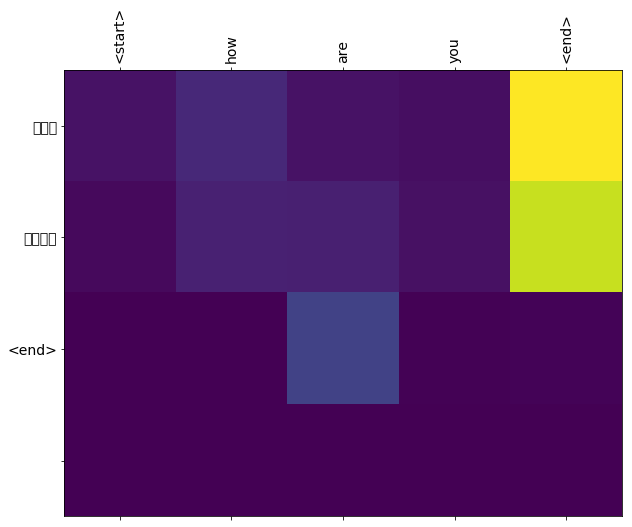

In [55]:
#making translations
translate(u'How are you?')

Input: <start> what is your name <end>
Predicted translation: तुझं नाव काय आहे <end> 


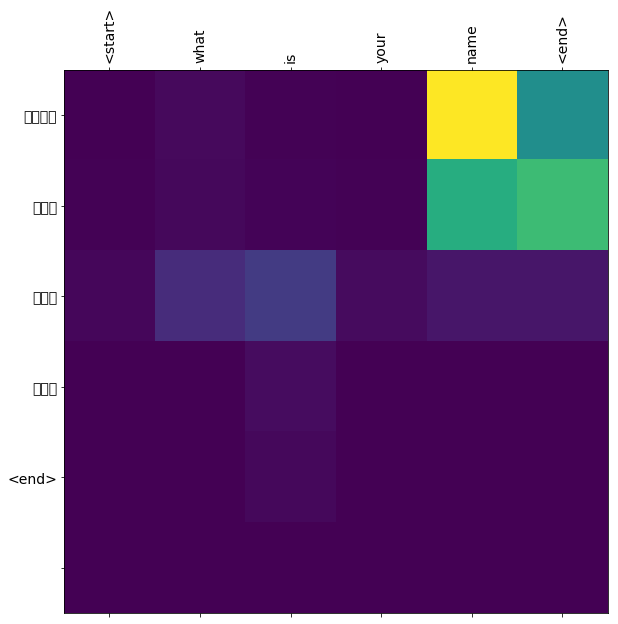

In [56]:
translate("WHAT IS YOUR NAME?")

Input: <start> i love you <end>
Predicted translation: मला तू खरच प्रेम आहे <end> 


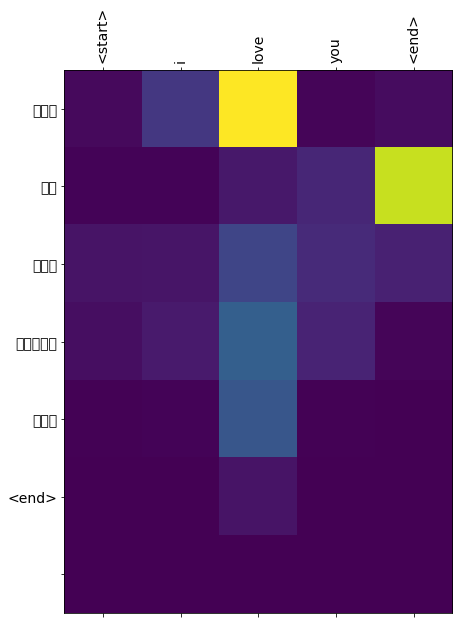

In [58]:
translate("I love you.")